# Vertical Regridding

Authors: [Jason Boutte](https://github.com/jasonb5) and [Jill Zhang](https://github.com/chengzhuzhang)

Updated: 11/07/24 [xcdat v0.7.3]

Related APIs:

- [xarray.Dataset.regridder.vertical](../generated/xarray.Dataset.regridder.vertical.rst)

We'll cover vertical regridding using `xgcm`. Two examples are outlined here to apply vertical regridding/remapping using ocean variables and atmosphere variables, respectively.

In the example below, we will be working with the `"ersstv5"` dataset (NOAA’s Extended Reconstructed Sea Surface Temperature monthly averages). The data used in this example can be found in the [xarray-data repository](https://github.com/pydata/xarray-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


## Example 1: Remapping Ocean Variables


In [1]:
%matplotlib inline

import gsw_xarray as gsw
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc

import warnings

warnings.filterwarnings("ignore")

### 1. Open dataset


In [2]:
# urls for sea water potential temperature (thetao) and salinity (so) from the NCAR model in CMIP6
urls = [
    "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/so/gn/v20190308/so_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc",
    "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/thetao/gn/v20190308/thetao_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc",
]

ds = xr.merge([xcdat.open_dataset(x, chunks={"time": 4}) for x in urls])

# lev coordinate is in cm and bounds is in m, convert lev to m
with xr.set_options(keep_attrs=True):
    ds.lev.load()
    ds["lev"] = ds.lev / 100
    ds.lev.attrs["units"] = "meters"

ds

2024-04-17 16:52:32,392 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2024-04-17 16:52:32,392 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2024-04-17 16:52:32,833 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2024-04-17 16:52:32,833 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.


<xarray.Dataset> Size: 117GB
Dimensions:    (lev: 60, nlat: 384, nlon: 320, time: 1980, d2: 2, vertices: 4,
                bnds: 2)
Coordinates:
  * lev        (lev) float64 480B 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
  * nlat       (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
    lat        (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 16kB 1850-01-15 13:00:00.000007 ... 2014-12-15 1...
Dimensions without coordinates: d2, vertices, bnds
Data variables:
    time_bnds  (time, d2) object 32kB dask.array<chunksize=(4, 2), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 2MB dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lev_bnds   (lev, d2) float32 480B dask.array<chunksize=(60, 2), meta=np.ndarray>
    so         (time, lev, nlat, nlon) float32 58GB dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
    nlon_bnds  (nlon, bnds) float64 5kB 0.5 1.5 1.5 2.5 ... 319.5 319.5 320.5
    thetao     (time, lev, nlat, nlon) float32 58GB dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         15
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-16T23:15:40Z
    ...                              ...
    sub_experiment_id:               none
    branch_time_in_parent:           219000.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    DODS_EXTRA.Unlimited_Dimension:  time

### 2. Create the output grid

Related API: [xcdat.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a vertical grid with a linear spaced level coordinate using `xcdat.create_grid`

Alternatively a grid can be loaded from a file, e.g.

```python
grid_urlpath = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/abrupt-4xCO2/r1i1p1f1/day/tas/gr2/v20180701/tas_day_GFDL-CM4_abrupt-4xCO2_r1i1p1f1_gr2_00010101-00201231.nc"

grid_ds = xcdat.open_dataset(grid_urlpath)

output_grid = grid_ds.regridder.grid
```


In [3]:
output_grid = xcdat.create_grid(z=xcdat.create_axis("lev", np.linspace(5, 537, 10)))

output_grid

<xarray.Dataset> Size: 240B
Dimensions:   (lev: 10, bnds: 2)
Coordinates:
  * lev       (lev) float64 80B 5.0 64.11 123.2 182.3 ... 418.8 477.9 537.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 160B -24.56 34.56 34.56 ... 507.4 507.4 566.6

### 3. Regridding using the `linear` method

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll interpolate salinity onto the new vertical grid.


2024-04-17 16:52:34,563 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2024-04-17 16:52:34,563 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.


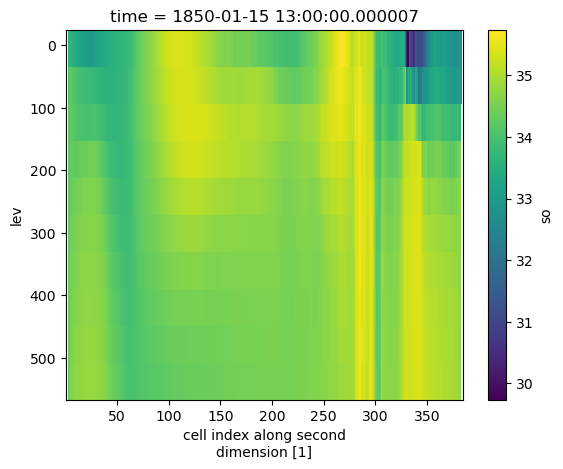

In [4]:
output = ds.regridder.vertical("so", output_grid, tool="xgcm", method="linear")

output.so.isel(time=0).mean(dim="nlon").plot()
plt.gca().invert_yaxis()

### 4. Regridding from depth to density space

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap salinity into density space.


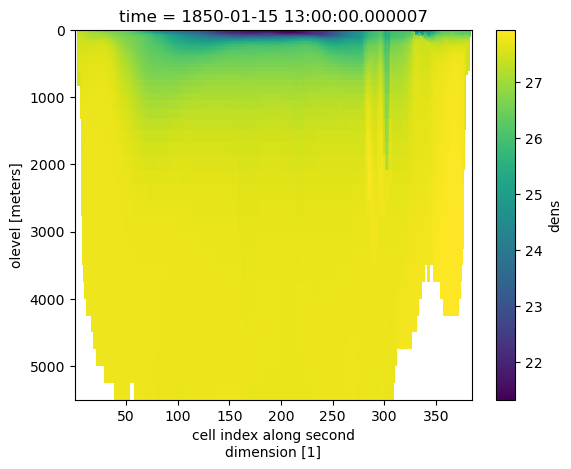

In [5]:
# Apply gsw function to calculate potential density from potential temperature (thetao) and salinity (so)
ds["dens"] = gsw.sigma0(ds.so, ds.thetao)

ds.dens.isel(time=0).mean(dim="nlon").plot()
plt.gca().invert_yaxis()

2024-04-17 16:52:43,882 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2024-04-17 16:52:43,882 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.


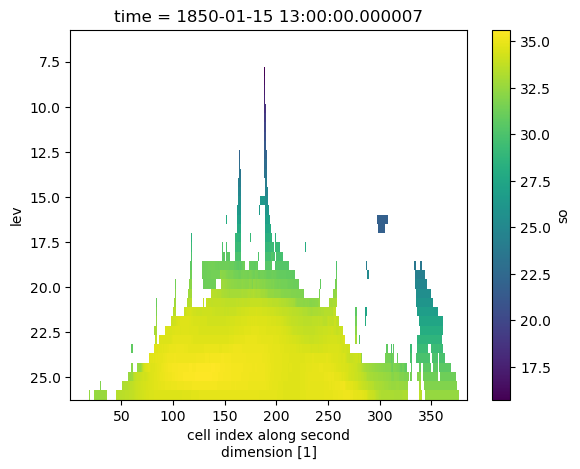

In [6]:
density_grid = xcdat.create_grid(z=xcdat.create_axis("lev", np.linspace(6, 26, 40)))

output = ds.regridder.vertical(
    "so", density_grid, tool="xgcm", method="linear", target_data="dens"
)

output.so.isel(time=0).mean(dim="nlon").plot()
plt.gca().invert_yaxis()

### 5. Regridding using the `conservative` method

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `conservative` method.

We'll transform model levels using conservative regridding. In order to perform the regridding we'll need two grid positions, the `lev` coordinate is **center** and we"ll create the **outer** points using `cf_xarray`"s `bounds_to_vertices`.


2024-04-17 16:52:50,627 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2024-04-17 16:52:50,627 [WARNING]: bounds.py(add_missing_bounds:191) >> The nlat coord variable has a 'units' attribute that is not in degrees.


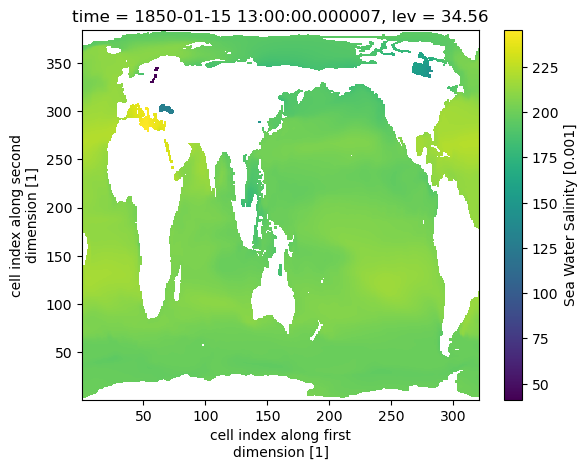

In [7]:
ds_olev = ds.cf.bounds_to_vertices("lev").rename({"lev_vertices": "olev"})

output = ds_olev.regridder.vertical(
    "so",
    output_grid,
    tool="xgcm",
    method="conservative",
    grid_positions={"center": "lev", "outer": "olev"},
)

output.so.isel(time=0).sel(lev=0, method="nearest").plot()

## Example 2: Remapping Atmosphere Variables


### 1. Open dataset


In [8]:
# Url of data from the E3SM model in CMIP6
url_ta = "https://esgf-data2.llnl.gov/thredds/dodsC/user_pub_work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r1i1p1f1/Amon/ta/gr/v20220830/ta_Amon_E3SM-2-0_historical_r1i1p1f1_gr_185001-189912.nc"
url_cl = "https://esgf-data2.llnl.gov/thredds/dodsC/user_pub_work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r1i1p1f1/Amon/cl/gr/v20220830/cl_Amon_E3SM-2-0_historical_r1i1p1f1_gr_185001-189912.nc"

ds_ta = xcdat.open_dataset(url_ta, chunks={"time": 4}, add_bounds=["Z"])
ds_cl = xcdat.open_dataset(url_cl, chunks={"time": 4})

### 2. Create the output grid

Related API: [xcdat.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a grid with a linear spaced level coordinate.


In [9]:
output_grid = xcdat.create_grid(z=xcdat.create_axis("lev", np.linspace(100000, 1, 13)))

output_grid

<xarray.Dataset> Size: 312B
Dimensions:   (lev: 13, bnds: 2)
Coordinates:
  * lev       (lev) float64 104B 1e+05 9.167e+04 8.333e+04 ... 8.334e+03 1.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 208B 1.042e+05 9.583e+04 ... -4.166e+03

### 3. Remapping air temperature on pressure levels to a set of target pressure levels.

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `log` method.

We'll remap pressure levels.


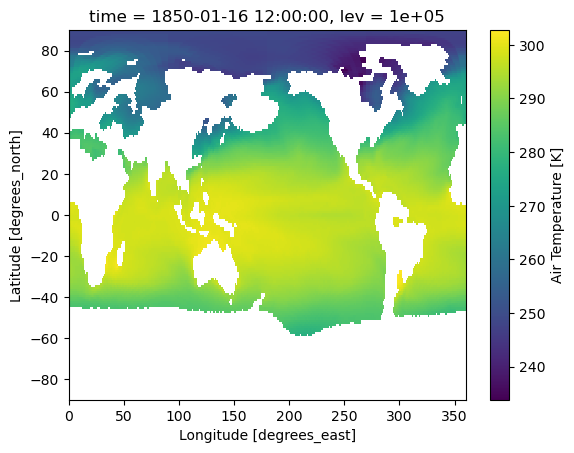

In [10]:
# Remap from original pressure level to target pressure level using logarithmic interpolation
# Note: output grids can be either ascending or descending
output_ta = ds_ta.regridder.vertical("ta", output_grid, method="log")

output_ta.ta.isel(time=0, lev=0).plot()

### 4: Remap cloud fraction from model hybrid coordinate to pressure levels

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap cloud fraction into pressure space.


In [11]:
# Build hybrid pressure coordinate
def hybrid_coordinate(p0, a, b, ps, **kwargs):
    return a * p0 + b * ps


pressure = hybrid_coordinate(**ds_cl.data_vars)

pressure

<xarray.DataArray (lev: 72, time: 600, lat: 180, lon: 360)> Size: 22GB
dask.array<add, shape=(72, 600, 180, 360), dtype=float64, chunksize=(72, 4, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 576B 0.9985 0.9938 0.9862 ... 0.0001828 0.0001238
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) object 5kB 1850-01-16 12:00:00 ... 1899-12-16 12:00:00

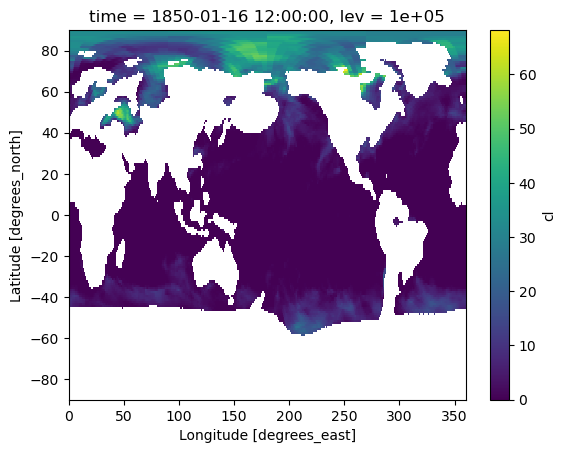

In [12]:
new_pressure_grid = xcdat.create_grid(
    z=xcdat.create_axis("lev", np.linspace(100000, 1, 13))
)

output_cl = ds_cl.regridder.vertical(
    "cl", new_pressure_grid, method="linear", target_data=pressure
)

output_cl.cl.isel(time=0, lev=0).plot()

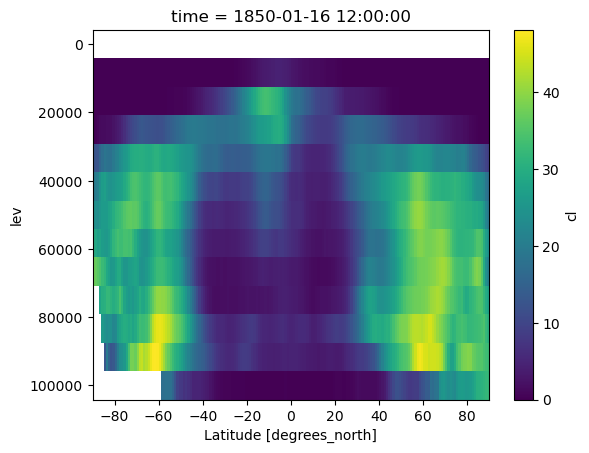

In [13]:
output_cl.cl.isel(time=0).mean(dim="lon").plot()
plt.gca().invert_yaxis()